In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATASET_DIR = "DatasetHAR"
POSITIONS = ["chest"]  # "chest", "left_hand", "right_hand", "left_knee", "right_knee"
ACTIVITIES = [0, 1, 2, 3, 4, 5]  # 0: Rest, 1: Fold clothes, 2: Sweep, 3: Walk, 4: Move boxes, 5: Bike
MAX_PLOTS = 10

LABEL_MAP = {
    0: "Rest",
    1: "Fold clothes",
    2: "Sweep",
    3: "Walk",
    4: "Move boxes",
    5: "Bike (stationary)",
}

ACCEL_COLS = {
    "chest": ["a_x_chest", "a_y_chest", "a_z_chest"],
    "left_hand": None,
    "right_hand": ["a_x_right_hand", "a_y_right_hand", "a_z_right_hand"],
    "left_knee": ["a_x_left_knee", "a_y_left_knee", "a_z_left_knee"],
    "right_knee": None
}

GYRO_COLS = {
    "chest": ["g_x_chest", "g_y_chest", "g_z_chest"],
    "left_hand": None,
    "right_hand": ["g_x_right_hand", "g_y_right_hand", "g_z_right_hand"],
    "left_knee": ["g_x_left_knee", "g_y_left_knee", "g_z_left_knee"],
    "right_knee": None
}

QUAT_COLS = {
    "chest": ["q_w_chest", "q_x_chest", "q_y_chest", "q_z_chest"],
    "left_hand": ["q_w_left_hand", "q_x_left_hand", "q_y_left_hand", "q_z_left_hand"],
    "right_hand": None,
    "left_knee": None,
    "right_knee": ["q_w_right_knee", "q_x_right_knee", "q_y_right_knee", "q_z_right_knee"]
}

In [3]:
def fetch_motion_data():
    recordings = []
    docs = []
    for subject_folder in sorted(os.listdir(DATASET_DIR)):
        subject_path = os.path.join(DATASET_DIR, subject_folder)
        if not os.path.isdir(subject_path):
            continue
        imu_file = os.path.join(subject_path, f"IMU{subject_folder}.csv")
        biomarkers_file = os.path.join(subject_path, f"Biomarkers{subject_folder}.csv")
        if not (os.path.exists(imu_file) and os.path.exists(biomarkers_file)):
            continue
        
        try:
            df_imu = pd.read_csv(imu_file)
            df_biomarkers = pd.read_csv(biomarkers_file)
            
            if len(df_biomarkers) > 0 and 'ActivityLabel' in df_biomarkers.columns:
                labels = df_biomarkers['ActivityLabel'].values
                labels_upsampled = np.repeat(labels, len(df_imu) // len(df_biomarkers) + 1)
                labels_upsampled = labels_upsampled[:len(df_imu)]
                df_imu['label'] = labels_upsampled
            else:
                continue
            
        except Exception as e:
            print(f"Error loading {subject_folder}: {e}")
            continue
        
        for position in POSITIONS:
            if ACCEL_COLS[position] is None:
                continue
            
            for label in ACTIVITIES:
                df_act = df_imu[df_imu["label"] == label].reset_index(drop=True)
                if len(df_act) == 0:
                    continue
                
                recordings.append(df_act)
                docs.append({
                    "activity": label,
                    "activity_name": LABEL_MAP.get(label, f"Activity {label}"),
                    "position": position,
                    "recording_id": subject_folder
                })

    print(f"Total recordings found: {len(recordings)}")
    return recordings, docs

In [5]:
def visualize_raw_recordings(recordings, docs, max_plots):
    plot_count = 0
    for df, doc in zip(recordings, docs):
        if plot_count >= max_plots:
            break
        position = doc["position"]
        accel_cols = ACCEL_COLS[position]
        gyro_cols = GYRO_COLS[position]
        quat_cols = QUAT_COLS[position]
        title = (
            f"Activity: {doc['activity_name']} (label={doc['activity']}), "
            f"Position: {position}, "
            f"Subject: {doc['recording_id']}"
        )
        time = np.arange(len(df))
        acc = df[accel_cols].to_numpy()
        acc_mag = np.linalg.norm(acc, axis=1)

        plt.figure(figsize=(15, 4))
        plt.title(f"{title} - Accelerometer (Raw)")
        plt.plot(time, acc[:, 0], label="Accel X")
        plt.plot(time, acc[:, 1], label="Accel Y")
        plt.plot(time, acc[:, 2], label="Accel Z")
        plt.plot(time, acc_mag, label="Accel Magnitude", linewidth=2)
        plt.xlabel("Sample")
        plt.ylabel("Acceleration (m/s²)")
        plt.ylim(-40, 40)
        plt.legend(loc="upper right")
        plt.grid(True)
        plt.show()

        if gyro_cols is not None:
            gyro = df[gyro_cols].to_numpy()
            gyro_mag = np.linalg.norm(gyro, axis=1)

            plt.figure(figsize=(15, 4))
            plt.title(f"{title} - Gyroscope (Raw)")
            plt.plot(time, gyro[:, 0], "--", label="Gyro X")
            plt.plot(time, gyro[:, 1], "--", label="Gyro Y")
            plt.plot(time, gyro[:, 2], "--", label="Gyro Z")
            plt.plot(time, gyro_mag, label="Gyro Magnitude", linewidth=2)
            plt.xlabel("Sample")
            plt.ylabel("Angular Velocity")
            plt.ylim(-400, 400)
            plt.legend(loc="upper right")
            plt.grid(True)
            plt.show()

        if quat_cols is not None:
            quat = df[quat_cols]

            plt.figure(figsize=(15, 4))
            plt.title(f"{title} - Orientation (Quaternion)")
            plt.plot(time, quat.iloc[:, 0], ":", label="qw")
            plt.plot(time, quat.iloc[:, 1], ":", label="qx")
            plt.plot(time, quat.iloc[:, 2], ":", label="qy")
            plt.plot(time, quat.iloc[:, 3], ":", label="qz")
            plt.xlabel("Sample")
            plt.ylabel("Quaternion Value")
            plt.ylim(-1, 1)
            plt.legend(loc="upper right")
            plt.grid(True)
            plt.show()

        plot_count += 1

Total recordings found: 360


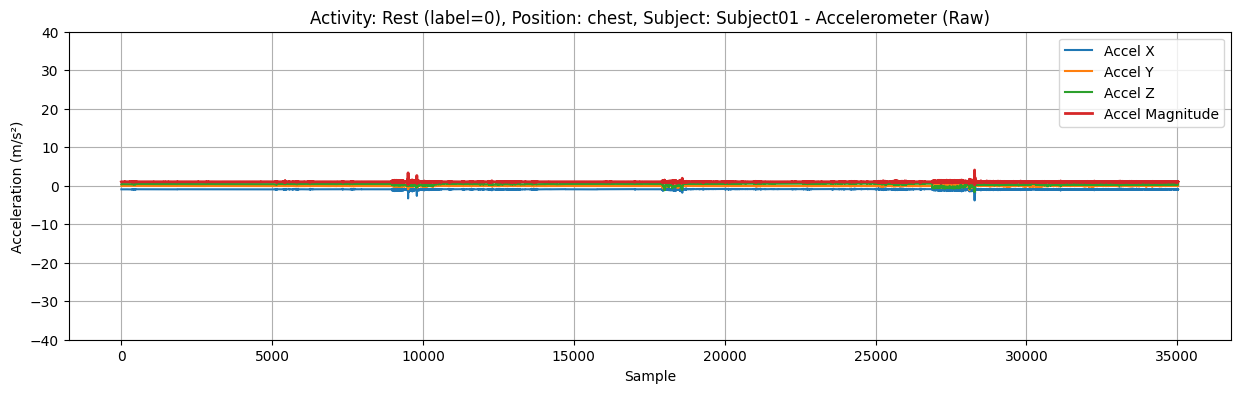

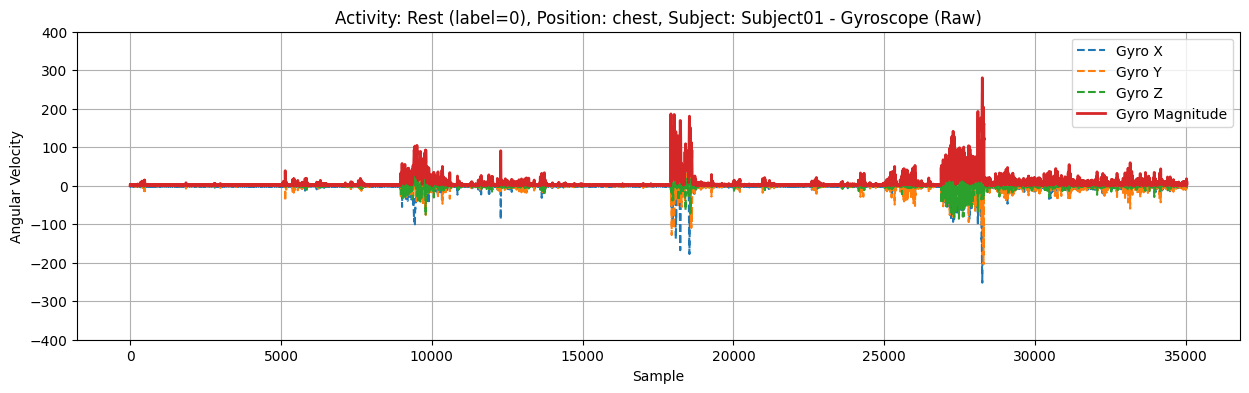

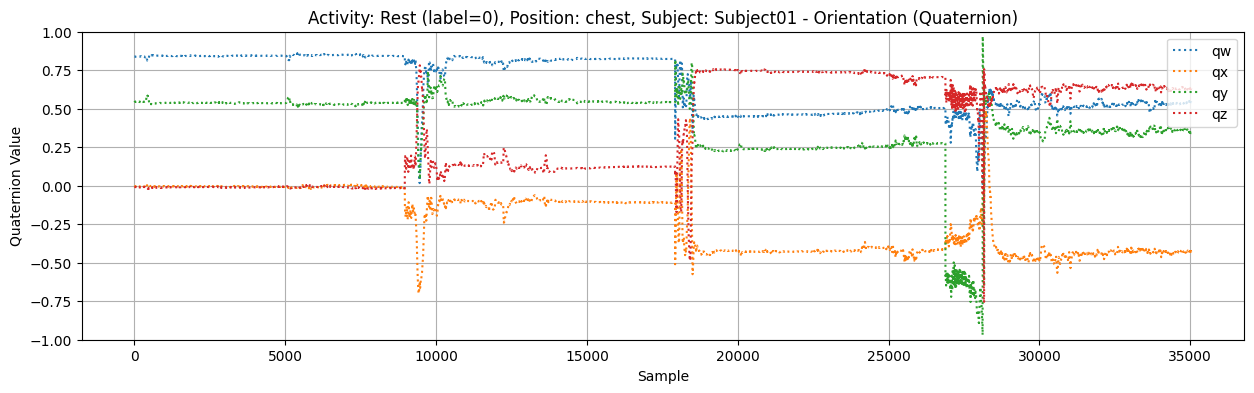

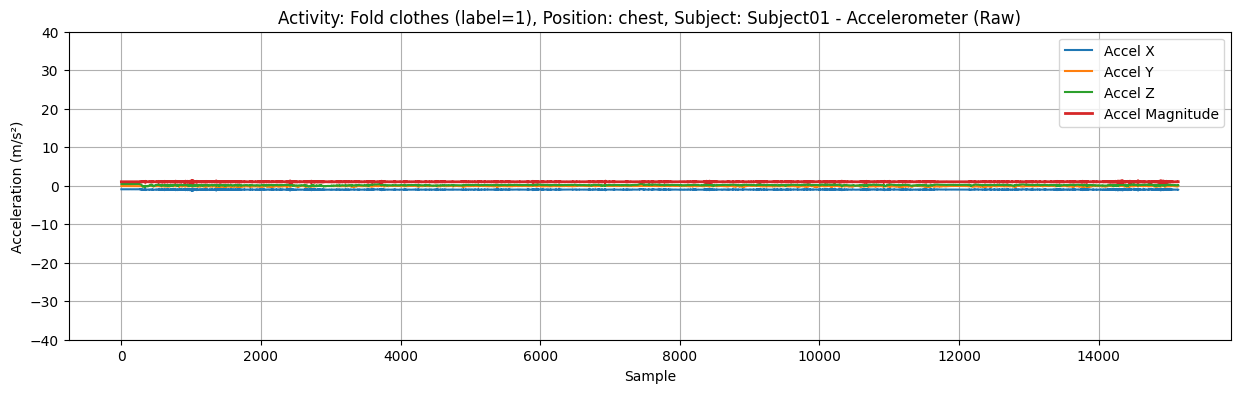

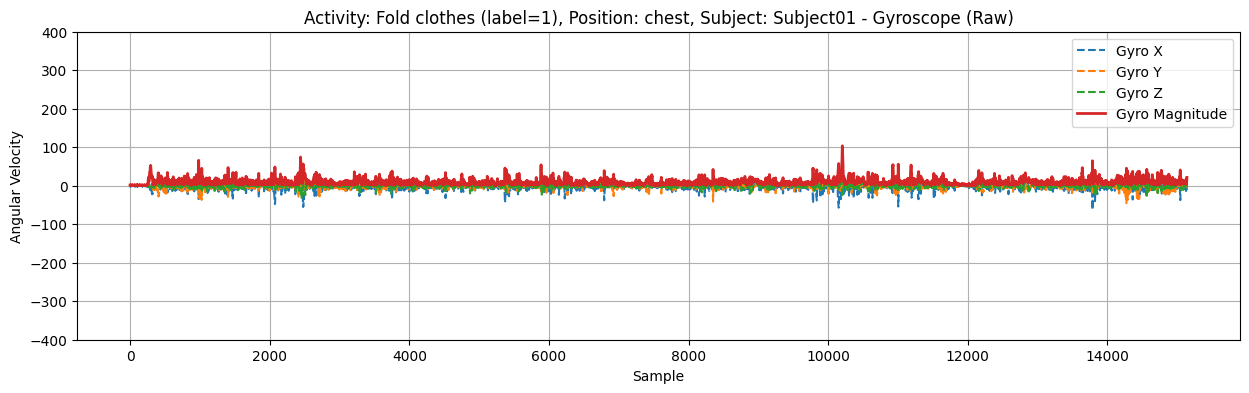

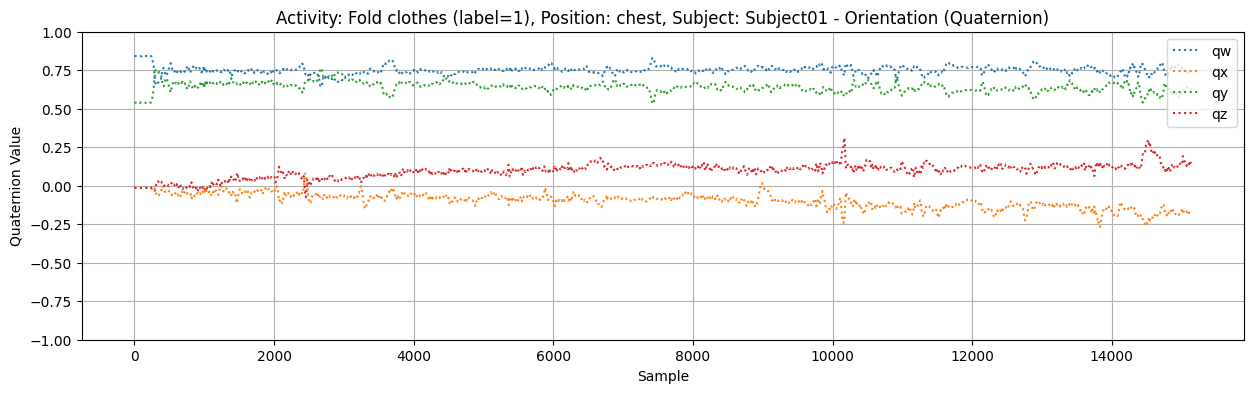

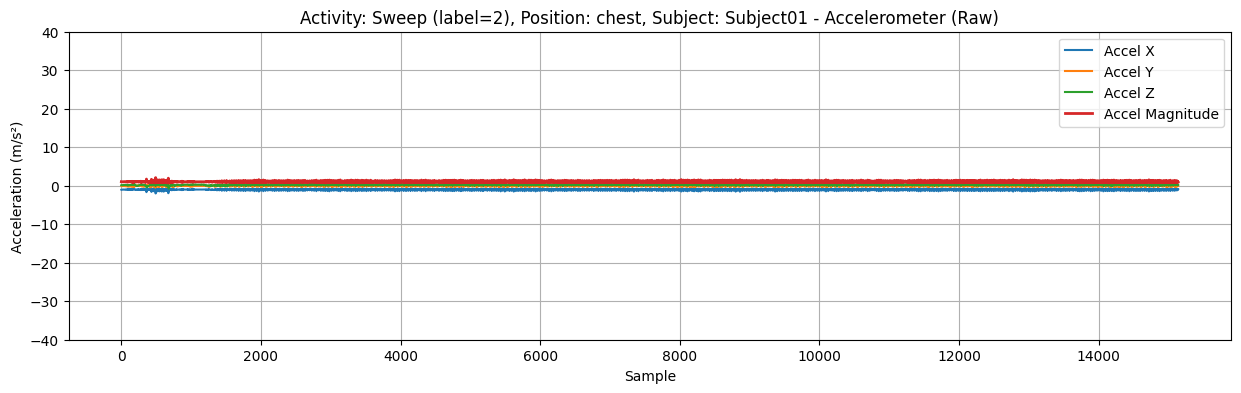

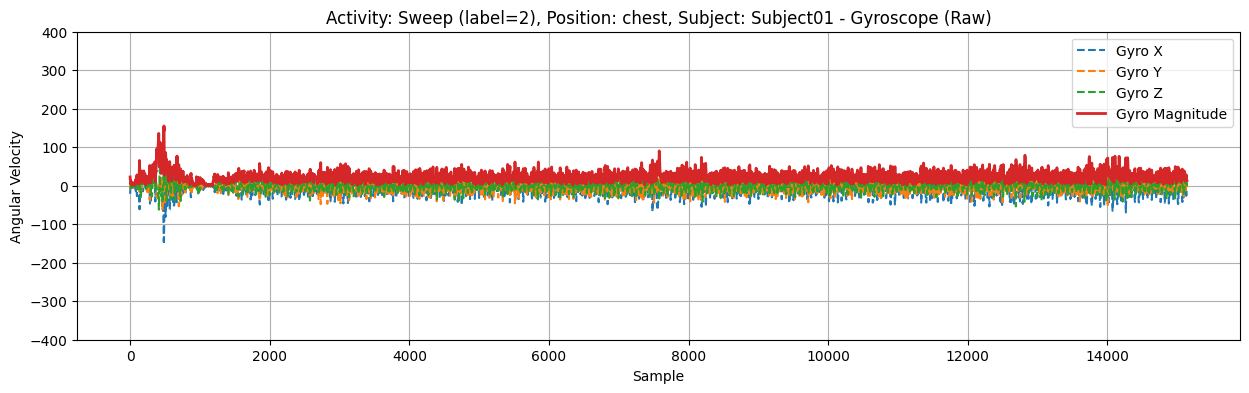

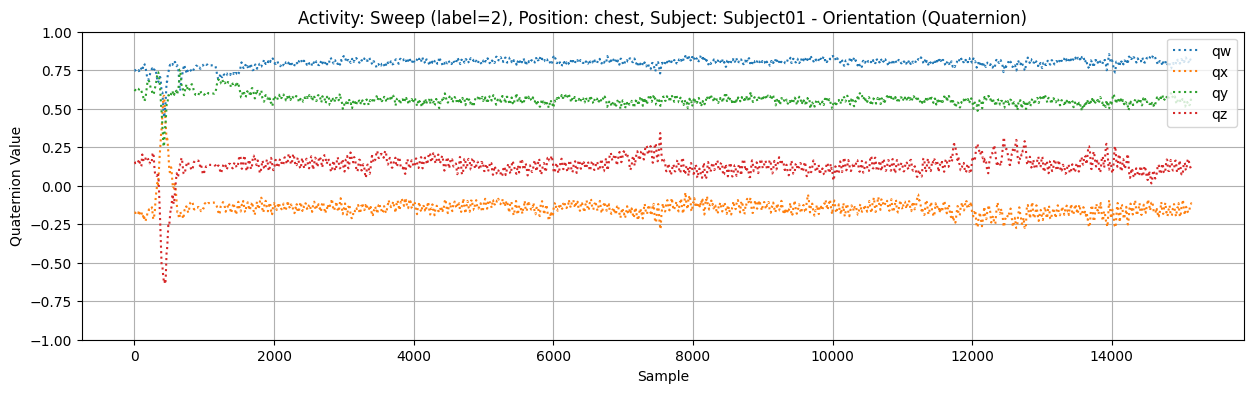

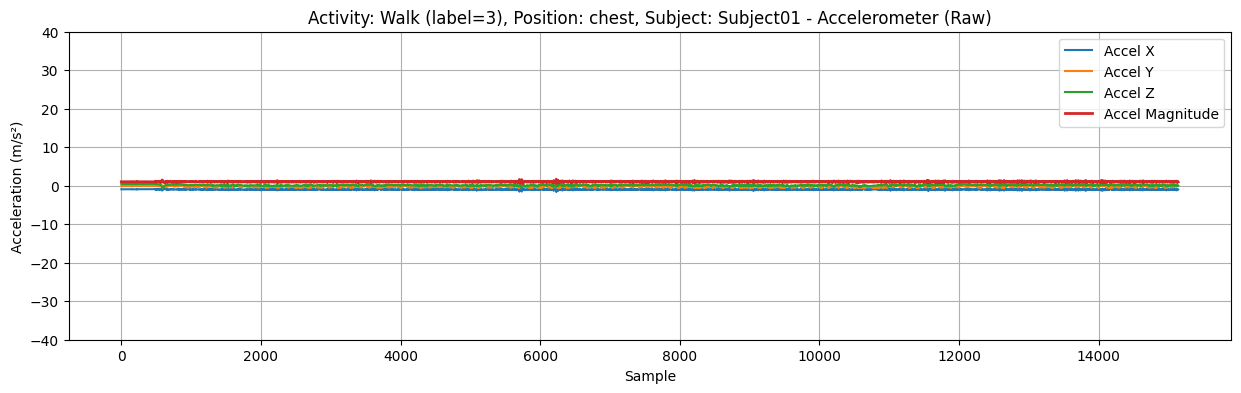

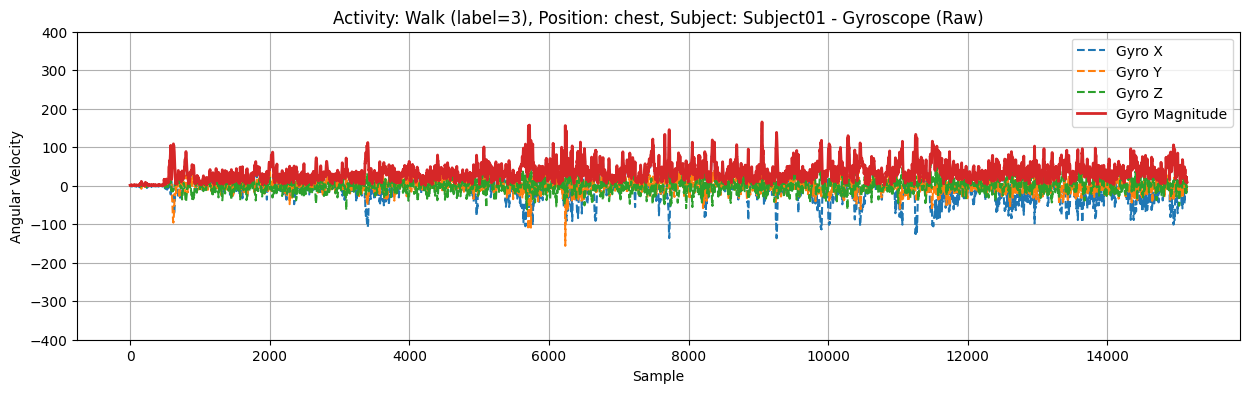

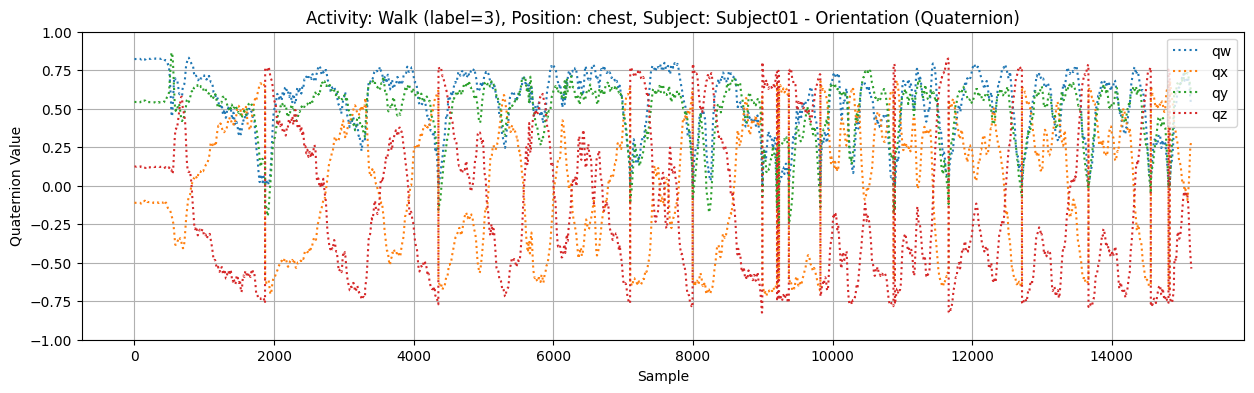

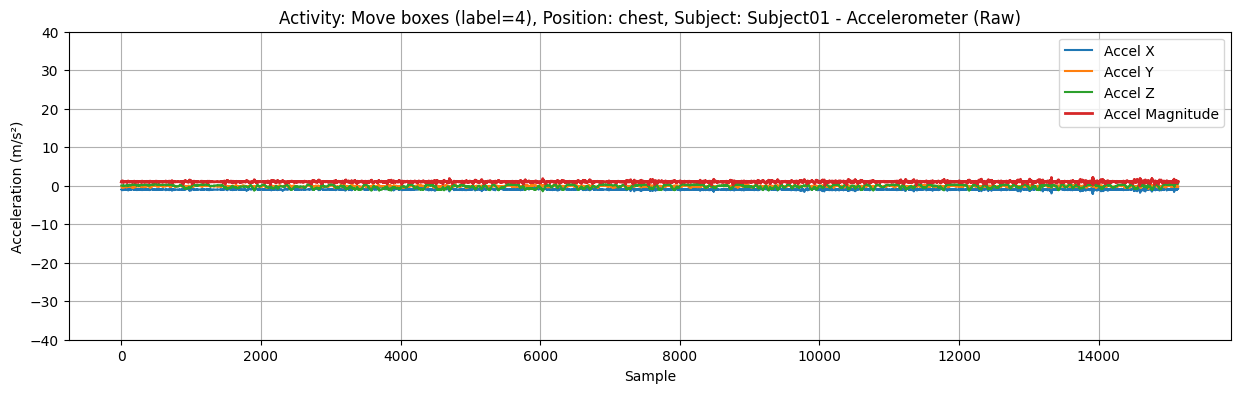

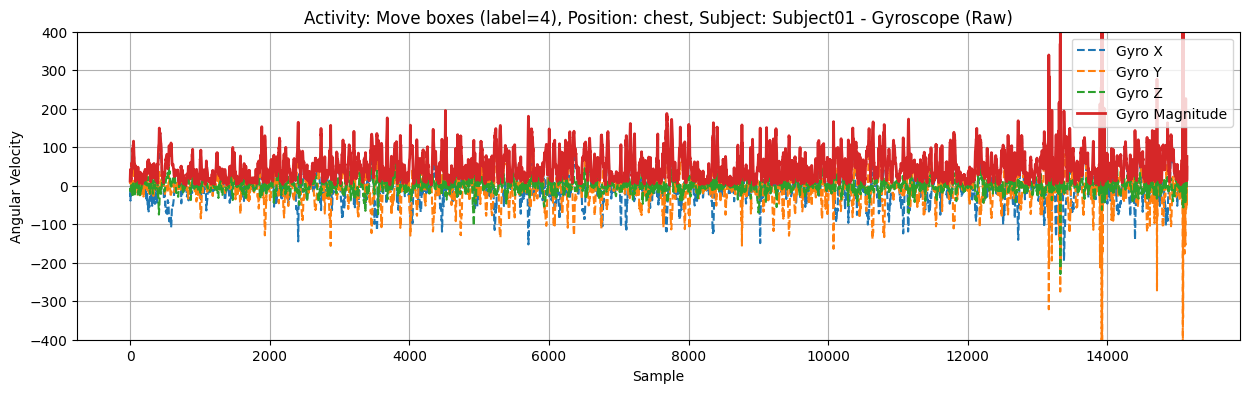

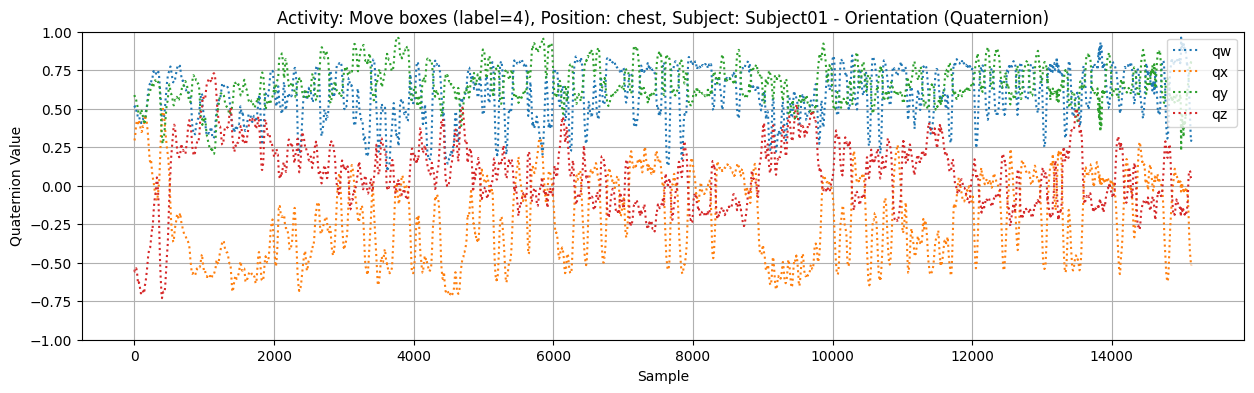

In [8]:
if __name__ == "__main__":
    data, docs = fetch_motion_data()
    visualize_raw_recordings(data, docs, max_plots=5)